In [2]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup
import CM_code.tjp_helper as tjp_helper
import time
import multiprocessing as mp 

imp.reload(tjp_helper)
imp.reload(sp)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

print('Lens bin: %g - %g'%(sp.zed.zl_min, sp.zed.zl_max))
print('Source bin: %g - %g'%(sp.zed.zs_min, sp.zed.zs_max))

year=1

Lens bin: 0.2 - 1.2
Source bin: 0.05 - 3.5


### Set lens redshift data

In [3]:
z_l, dndz_l, zleff = sp.zed.get_dndz_spec(gtype='lens', 
                                          year=year, 
                                          zlmin=0.2,
                                          zlmax=1.2,
                                          z_vec_len=300,
                                          normalise=True)

# convert redshifts for lenses and sources to scale factors
La_arr = 1. / (1. + z_l)
print(zleff)
zl=0

0.6999999999999998


### Compute Pgg(k)

In [5]:
# wavenumbers and scale factors for all-space power spectrum
#k_arr = np.geomspace(1E-4, 5E4, 3*sp.interp_len)
k_arr = np.geomspace(1E-4,5E4,3000)

a_arr = np.linspace(0.1,1,32)

# # must flip array because ccl wants scale factors ascending (z_0 == a_1)
pk_ll, pk_ls, pk_ss = sp.halo.get_Pgg_2D(k_arr=k_arr, a_arr=a_arr, 
                        year=year, onehalo=True)

pk_NoHOD = ccl.power.nonlin_power(sp.zed.cosmo_SRD, k_arr, a_arr[-1])

pk_joint = sp.halo.get_joint_Pgg(k_arr, a_arr, year)

pk_gM2D = sp.halo.get_Pk2D('gm', k_arr, a_arr)

pk_MM2D = sp.halo.get_Pk2D('mm', k_arr, a_arr)

pk_ll done...
pk_ls done...
pk_ss done...
returning: Pk_ll, Pk_ls, Pk_ss


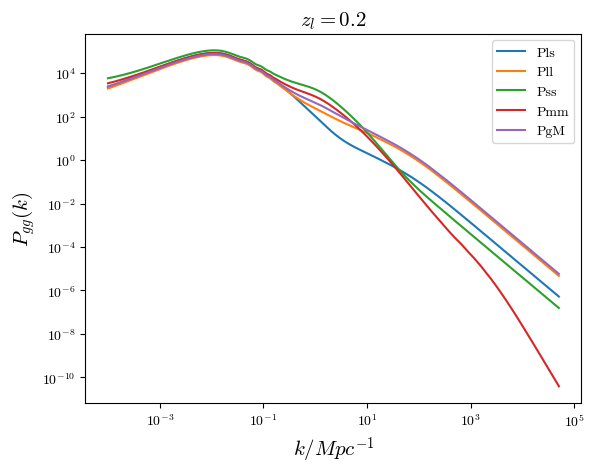

In [779]:
plt.figure()
plt.plot(k_arr, pk_ls.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_Nic))
plt.plot(k_arr, pk_ll.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_Nic))
plt.plot(k_arr, pk_ss.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_Nic))
#plt.plot(k_arr, pk_ls.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_SRD))
#plt.plot(k_arr, pk_ss.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_ZuMa))
#plt.plot(k_arr, pk_joint.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_SRD))
plt.plot(k_arr, pk_MM2D.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_Nic))
plt.plot(k_arr, pk_gM2D.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_Nic))
plt.title(r'$z_{l} = %g$'%(z_l[zl]), fontsize=15)
plt.xlabel(r'$k / Mpc^{-1}$', fontsize=15)
plt.ylabel(r'$P_{gg}(k)$', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(['Pls', 'Pll', 'Pss', 'Pmm', 'PgM'])
plt.savefig('compare_Pgg_differentHOD.png', bbox_inches='tight', dpi=300)

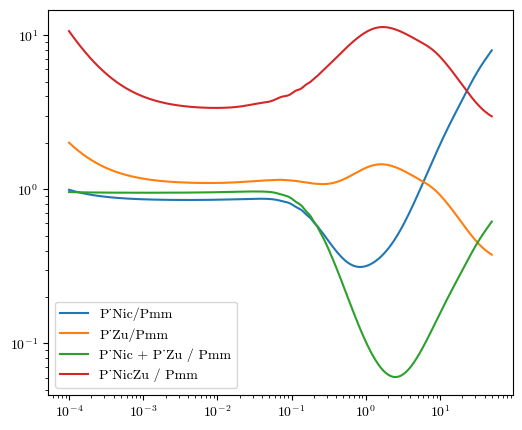

In [700]:
# construct power spectra ratios
# do everything relative to Pmm-nonlin

Nic = pk_ll.eval(k_arr, La_arr[0], cosmo=sp.zed.cosmo_Nic)/pk_NoHOD
Zu = pk_ss.eval(k_arr, La_arr[0], cosmo=sp.zed.cosmo_ZuMa)/pk_NoHOD
NicZu2 = pk_ls.eval(k_arr, La_arr[0], cosmo=sp.zed.cosmo_SRD)/pk_NoHOD
NicZu1 = pk_joint.eval(k_arr, La_arr[0], cosmo=sp.zed.cosmo_SRD)/pk_NoHOD

plt.figure(figsize=[6,5])
plt.loglog()
plt.plot(k_arr, Nic)
plt.plot(k_arr, Zu)
plt.plot(k_arr, NicZu2)
plt.plot(k_arr, NicZu1)


plt.legend(['P_Nic/Pmm','P_Zu/Pmm', 'P_Nic + P_Zu / Pmm', 'P_NicZu / Pmm'])

In [807]:
p_ls = sp.halo.get_1D_power(corr='gg', k_arr=k_arr, a=a_arr[-1])

In [7]:
class Profile2ptHOD(ccl.halos.Profile2pt):
    def __init__(self, r_corr=0.3):
        self.r_corr = r_corr
        
    def fourier_2pt(self, prof, cosmo, k, M, a, prof2, mass_def=None):
        uk1 = prof._fourier_variance(sp.zed.cosmo_SRD, k, M ,a, mass_def)
        if prof2 is not None:
            uk2 = prof2._fourier_variance(sp.zed.cosmo_SRD, k, M ,a, mass_def)
            return (uk1 + uk2) / 2 * (1+self.r_corr)
        elif prof2 is None:
            return uk1

# 2pt cumulant of HOD
HOD2pt = Profile2ptHOD()
Lpg = sp.halo.LensHOD(sp.halo.cM)
Spg = sp.halo.SourceHOD(sp.halo.cM)

# wavenumbers and scale factors for all-space power spectrum
#k_arr = np.geomspace(1E-4, 5E4, 3*sp.interp_len)k_arr = np.geomspace(1E-4,5E4,3000)

a_arr = np.linspace(0.1,1,32)


p_ls1D = ccl.halos.halomod_power_spectrum(sp.zed.cosmo_SRD, sp.halo.hmc, k_arr, a_arr[-1],
                                         prof=Lpg, prof2=Spg, 
                                         prof_2pt=None,
                                         normprof1=True, normprof2=True, get_1h=True)

p_ll1D = ccl.halos.halomod_power_spectrum(sp.zed.cosmo_SRD, sp.halo.hmc, k_arr, a_arr[-1],
                                         prof=Lpg, prof_2pt=HOD2pt,
                                         normprof1=True)

p_ss1D = ccl.halos.halomod_power_spectrum(sp.zed.cosmo_SRD, sp.halo.hmc, k_arr, a_arr[-1],
                                          prof=Spg, prof_2pt=HOD2pt,
                                          normprof1=True)

#pls_2D = sp.halo.get_Pk2D('gg', k_arr, a_arr)

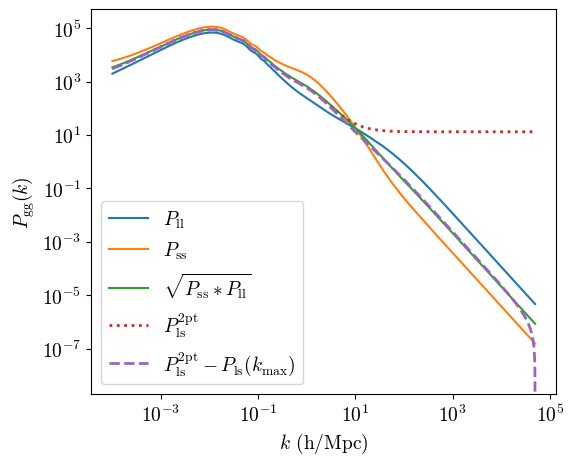

In [31]:
plt.figure(figsize=[6,5])
plt.loglog(k_arr, p_ll1D, label=r'$P_{\rm ll}$')
plt.loglog(k_arr, p_ss1D, label=r'$P_{\rm ss}$')
plt.loglog(k_arr, np.sqrt(p_ll1D * p_ss1D), label=r'$\sqrt{P_{\rm ss}*P_{\rm ll}}$')
plt.loglog(k_arr, p_ls1D, ls=':', lw=2, label=r'$P_{\rm ls}^{\rm 2pt}$')
plt.loglog(k_arr, p_ls1D-min(p_ls1D), lw=2, ls='--', label=r'$P_{\rm ls}^{\rm 2pt} - P_{\rm ls}(k_{\rm max})$')
plt.legend(fontsize=14);
# plt.title(r'$z = 0$', fontsize=14);
plt.xlabel(r'$k$ (h/Mpc)', fontsize=14);
plt.ylabel(r'$P_{\rm gg}(k)$', fontsize=14);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.savefig('compare_power_spectra.pdf', bbox_inches='tight', dpi=300)

In [797]:
pls_k_a = np.zeros([len(a_arr), len(k_arr)])
for i in range(len(a_arr)):
    pls_k_a[i,:] = sp.halo.get_1D_power(corr='gg', k_arr=k_arr, a=a_arr[i], year=year)
    
pk_gg2D = ccl.pk2d.Pk2D(cosmo=sp.halo.cosmo_SRD, pk_arr=pls_k_a, a_arr=a_arr,
                      lk_arr=np.log(k_arr), is_logp=False)

found P(k,0.1)
found P(k,0.129032)
found P(k,0.158065)
found P(k,0.187097)
found P(k,0.216129)
found P(k,0.245161)
found P(k,0.274194)
found P(k,0.303226)
found P(k,0.332258)
found P(k,0.36129)
found P(k,0.390323)
found P(k,0.419355)
found P(k,0.448387)
found P(k,0.477419)
found P(k,0.506452)
found P(k,0.535484)
found P(k,0.564516)
found P(k,0.593548)
found P(k,0.622581)
found P(k,0.651613)
found P(k,0.680645)
found P(k,0.709677)
found P(k,0.73871)
found P(k,0.767742)
found P(k,0.796774)
found P(k,0.825806)
found P(k,0.854839)
found P(k,0.883871)
found P(k,0.912903)
found P(k,0.941935)
found P(k,0.970968)
found P(k,1)


In [812]:
pk2D = sp.halo.get_Pk2D(corr='gg', k_arr=k_arr, a_arr=a_arr)

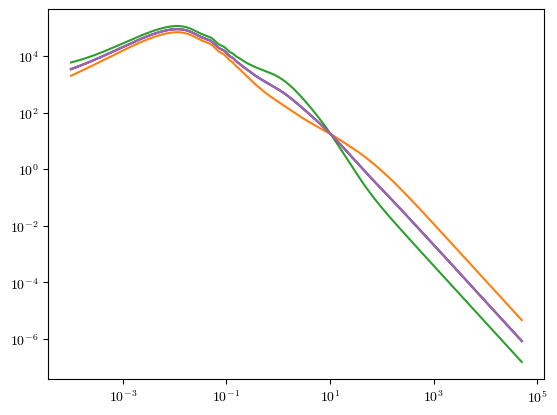

In [817]:
plt.loglog(k_arr, p_ls, ls='--')
plt.loglog(k_arr, p_ll1D)
plt.loglog(k_arr, p_ss1D)
plt.loglog(k_arr, pk2D.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_SRD))
plt.loglog(k_arr, pk_gg2D.eval(k_arr, a_arr[-1], cosmo=sp.zed.cosmo_SRD))

### Compute xi_gg  

In [920]:
# create a long theta vector to convert to r_p for integration
# is likely too low a resolution for accurate integration
theta_long = np.logspace(np.log10(sp.theta_min), np.log10(sp.theta_max), sp.N_bins)

# convert to Mpc/h for definition with Pi
# there are our bin centers
r_p = np.logspace(np.log10(0.1), np.log10(10), 7) #Mpc/h

# define max and min r based on combination of rp and Pi
rmax = np.sqrt(np.max(r_p)**2 + (200.+1)**2) # WE NEED UNITS TO BE CONSISTENT HERE
rmin = np.sqrt(np.min(r_p)**2 - 1E-4**2)

# set some arbitrary 3D separations r to compute xi_gg
r = np.logspace(np.log10(rmin), np.log10(rmax), sp.interp_len) # Mpc/h

xi_gg = np.zeros([len(r), len(z_l)])
xi_mm = np.zeros([len(r), len(z_l)])
for zl in range(len(z_l)):
    # r is in Mpc/h so we need to convert back to h
    xi_gg[:,zl] = ccl.correlations.correlation_3d(sp.zed.cosmo_SRD, La_arr[zl], 
                                       r / (sp.pa.HH0/100.), pk2D)

KeyboardInterrupt: 

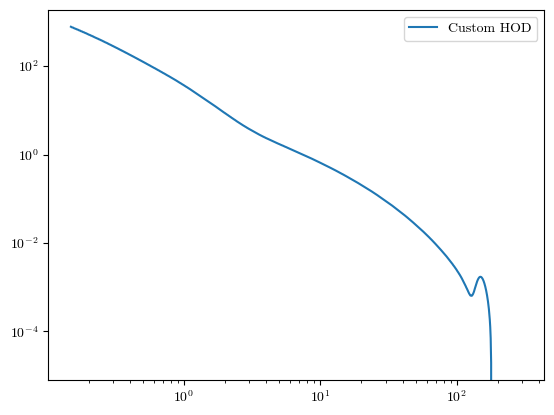

In [830]:
plt.plot(r / (sp.pa.HH0/100.), xi_gg[:,0])
plt.xscale('log')
plt.yscale('log')
plt.legend(['Custom HOD', 'Nin-Pmm'])

### Compute xi_ls

In [831]:
# comoving radial distance from observer to lenses
chi_lens = ccl.comoving_radial_distance(sp.zed.cosmo_SRD, La_arr) * (sp.pa.HH0 / 100.)

# L.o.S pair separation array
minPiPos = 1E-4
max_int = 200. # We integrate the numerator out to 200 Mpc/h away from the lenses because the correlation is zero outside of this.
maxPiPos = max_int
Pi_pos = np.logspace(np.log10(minPiPos), np.log10(maxPiPos), sp.interp_len)

# Pi can be positive or negative, so now flip this and include the negative values, but only down to z=0
# And avoid including multiple of the same values - this messes up some integration routines.
Pi = [0]*len(z_l)
chismin = ccl.comoving_radial_distance(sp.zed.cosmo_SRD, 
                                   1./(1.+3.393976853817444635e-03)
                                  ) * (sp.pa.HH0 / 100.)
try:
    for zi in range(len(z_l)):
        Pi_pos_vec= list(Pi_pos)[1:]
        Pi_pos_vec.reverse()
        index_cut = next(j[0] for j in enumerate(Pi_pos_vec) if j[1]<=(chi_lens[zi]-chismin))
        Pi[zi] = np.append(-np.asarray(Pi_pos_vec[index_cut:]), np.append([0],Pi_pos))  
except StopIteration:
    Pi[-1] = Pi_pos

In [832]:
def calculate_xi_ls(zl, r, r_p, Pi, xi_gg):
        
        try:
            # xi_gg is a function of r, so we interpolate it across r to later find x_ls as a function of rp and pi
            xi_interp_r = scipy.interpolate.interp1d(r, xi_gg[:,zl])
            # preallocate array for xi(rp,pi(zl))
            xi_ofPi = np.zeros([len(Pi[zl]), len(r_p)])
            for ri in range(len(r_p)):
                for pi in range(len(Pi[zl])):
                    rp_pi_zl = np.sqrt((r_p[ri]**2 + Pi[zl][pi]**2))
                    xi_ofPi[pi, ri] = xi_interp_r(rp_pi_zl)
        except ValueError:
            print('Interpolation failed')

        return xi_ofPi

# wrap function inside another function so it can be passsed to multiprocessing with a single set
# of iterables
global wrap_for_mp
def wrap_for_mp(iterable):
    return calculate_xi_ls(zl=iterable, r=r, r_p=r_p, Pi=Pi, xi_gg=xi_gg), iterable

# preallocate list for outputs
xi_ls = [0] * len(z_l)

# set first set of indices to be passed to multiprocessing and computed 
iterables = list(range(len(z_l)))

# open multiprocess pool in with statement so it closes after it's complete
with mp.Pool(sp.poolsize) as p:
    # output values and process ID (imap should ensure correct order)
    xi_ls, order = zip(*p.imap(wrap_for_mp, iterables))

# run quick test to ensure order of outputs was preserved
check_order = list(order)
if check_order == iterables:
    print('Order preserved for zl indices %d-%d'%(iterables[0],iterables[-1]))
else:
    print('Order scrambled, data corrupted, exiting...')
    exit()

print('xi_ls estimation complete')

com_Pi = [0]*len(z_l)
z_Pi = [0]*len(z_l)
# get comoving distance values associated to Pi
for zl in range(len(z_l)):
    com_Pi[zl] = chi_lens[zl] + Pi[zl]
    # CCL wants distance in Mpc but we are working in Mpc/h
    z_Pi[zl] = (1./ccl.scale_factor_of_chi(sp.zed.cosmo_SRD, com_Pi[zl] / (sp.pa.HH0_t/100.))) - 1. 

del com_Pi

Order preserved for zl indices 0-299
xi_ls estimation complete


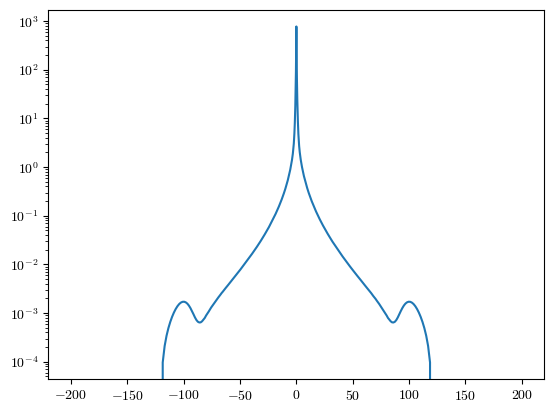

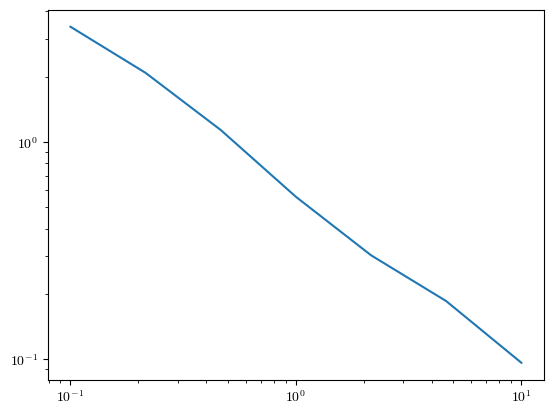

In [833]:
xi_mean = np.zeros_like(r_p)
for i in range(len(r_p)):
    xi_mean[i] = np.mean(xi_ls[:][:][i])

zl=0

zPi_ph, dNdz_pi, p_zpi_zph = get_source_zdata(zl, ztype='phot', norm=False)
plt.figure()
rp = 0
plt.plot(Pi[0], xi_ls[0][:,rp])
plt.yscale('log')
#plt.xscale('log')

plt.figure()
plt.xscale('log')
plt.yscale('log')
int_xi_ls = scipy.integrate.simps(dNdz_pi[:,None]*xi_ls[zl], Pi[zl], axis=0)
plt.plot(r_p, int_xi_ls)

#plt.plot(z_Pi[zl], dNdz_pi)
#plt.yticks([0.001, 0.01, 0.1, 1.0],['0.001', '0.01', '0.1', '1.0'],fontsize=14)

In [834]:
# get weights
weights = sp.zed.get_weights()

# start by constructing dndz_Pi using SRD parameterisation
zPi_ph = [0] * len(z_l)
zPi_ph_norm = [0] * len(z_l)
zPi_full = [0] * len(z_l)
dNdz_pi = [0] * len(z_l)
dNdz_pi_norm = [0] * len(z_l)
p_zpi_zph = [0] * len(z_l)
p_zpi_zph_norm = [0] * len(z_l)

In [835]:
imp.reload(sp)
def get_source_zdata(zl, ztype, norm):

    # get dndz_pi * p(zpi,zph) at each zl to integrate with xi_ls
    if ztype=='phot' and norm==False:

        zPi_ph, dNdz_pi, p_zpi_zph = sp.zed.get_dndz_phot(gtype='source',
                                                       year=year,
                                                       zsmin=min(z_Pi[zl]),
                                                       zsmax=max(z_Pi[zl]),
                                                       z_vec_len=len(z_Pi[zl]),
                                                       normalise=False,
                                                       for_Pi=True,
                                                       z_Pi=z_Pi[zl]
                                                       )
        return zPi_ph, dNdz_pi, p_zpi_zph


    # get full range photo-z zpi' s to integrate over and 
    # normalisation factor (integral of dndz_pi * p(zpi,zph) 
    # for the full redshift range
    # set normalise to false as this will already be normalised over spec-z
    if ztype=='phot' and norm==True:

        zPi_ph_norm, dNdz_pi_norm, p_zpi_zph_norm = sp.zed.get_dndz_phot(gtype='source',
                                                                      year=year,
                                                                      z_vec_len=len(z_Pi[zl]),
                                                                      normalise=False, 
                                                                      for_Pi=True
                                                                      )
        return zPi_ph_norm, dNdz_pi_norm, p_zpi_zph_norm

    # get full spec-z redshifts to normalsie over
    if ztype=='spec':    

        zPi_full, *_ = sp.zed.get_dndz_spec(gtype='source',
                                         year=year,
                                         z_vec_len=len(z_Pi[zl])
                                         )
        return zPi_full

In [885]:
# define a function to compute the integral over z_s -> relabelled to z_pi
def integrate_zPi(zl):
    
    # get redshifts for numerator integral
    zPi_ph, dNdz_pi, p_zpi_zph = get_source_zdata(zl, ztype='phot', norm=False)

    # get redshifts for denominator integral
    zPi_ph_norm, dNdz_pi_norm, p_zpi_zph_norm = get_source_zdata(zl, ztype='phot', norm=True)

    # get full source spec-z 
    zPi_full = get_source_zdata(zl, ztype='spec', norm=None)

    # preallocate arrays to store data
    num_igl_zPi = np.zeros([len(r_p), len(zPi_ph)])
    denom_igl_zPi = np.zeros([len(r_p), len(zPi_ph)])

    for ri in range(len(r_p)):
        # rows are rp, columns represent different Pi values
        
        #slow ugly nested for loop
        # num_igd_zPi = np.zeros_like(p_zpi_zph[zl])
        # denom_igd_zPi = np.zeros_like(p_zpi_zph_norm[zl])

        # for zpi in range(len(z_Pi[zl])):
        #     for zph in range(len(zPi_ph[zl])):
        #         num_igd_zPi[zpi,zph] = dNdz_pi[zl][zpi] * xi_ls[zl][zpi,ri] * p_zpi_zph[zl][zpi,zph]
        #         denom_igd_zPi[zpi,zph] = dNdz_pi_norm[zl][zpi] * p_zpi_zph_norm[zl][zpi,zph]
        
        num_igd_zPi = dNdz_pi[:,None] * xi_ls[zl][:,ri,None] * p_zpi_zph[:,:]
        denom_igd_zPi = dNdz_pi[:,None] * p_zpi_zph[:,:]
    
        # for P(zpi,zph), we want to integrate over the z_Pi values, these are rows so axis=0
        # we normalise over the full spec z range as the slice in z_Pi[zl] only represents 
        # the fact that xi is zero outside this slice
        num_igl_zPi[ri,:] = scipy.integrate.simps(num_igd_zPi, z_Pi[zl], axis=0) 

        denom_igl_zPi[ri,:] = scipy.integrate.simps(denom_igd_zPi, z_Pi[zl], axis=0)

    # this leaves us with an array that is [len(rp) x len(zph)]
    return num_igl_zPi, denom_igl_zPi, zPi_ph, zPi_ph_norm, p_zpi_zph

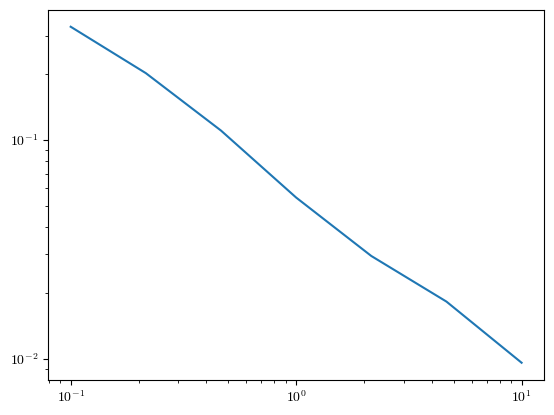

In [886]:

zPi_ph, dNdz_pi, p_zpi_zph = get_source_zdata(zl, ztype='phot', norm=False)
zPi_ph_norm, dNdz_pi_norm, p_zpi_zph_norm = get_source_zdata(zl, ztype='phot', norm=True)

num_igl_zPi, denom_igl_zPi, zPi_ph, zPi_ph_norm, p_zpi_zph = integrate_zPi(zl)

plt.plot(r_p, num_igl_zPi[:,1]/denom_igl_zPi[:,1])
plt.xscale('log')
plt.yscale('log')

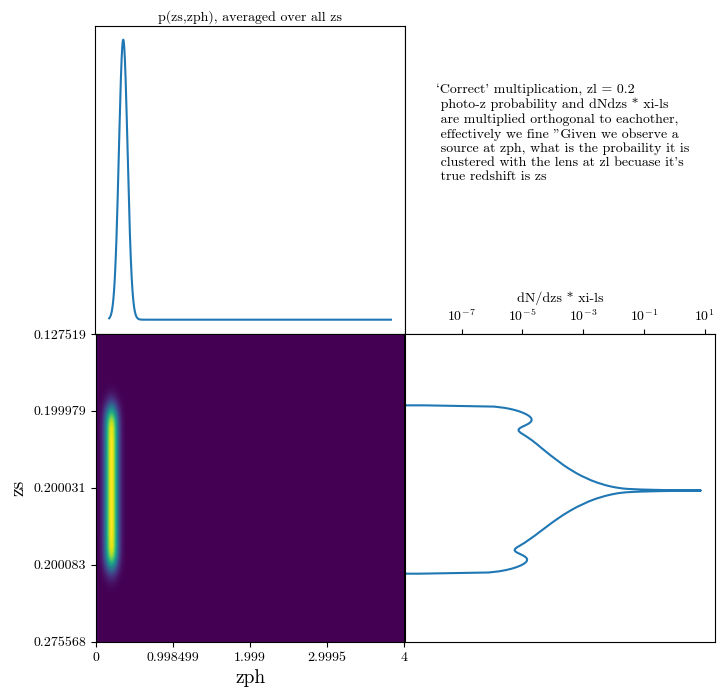

In [519]:
full_mul = dNdz_pi * p_zpi_zph[:,:] * xi_ls[0][:,0]

full_mul_none = dNdz_pi[:,None] * xi_ls[0][:,0,None] * p_zpi_zph[:,:]

dN_xi = dNdz_pi * xi_ls[0][:,0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=[8,8],
                                             gridspec_kw={'hspace':0,'wspace':0})


ax1.plot(zPi_ph, np.mean(p_zpi_zph,axis=0))
ax1.set_xlabel('p(zs,zph), averaged over all zs')
ax1.xaxis.set_label_position('top')


ax3.matshow(full_mul_none)

ax4.plot(dN_xi, z_Pi[0])
ax4.set_xscale('log')
ax4.xaxis.set_ticks_position('top')
ax4.set_xlabel('dN/dzs * xi-ls')
ax4.xaxis.set_label_position('top')

ax3.set_xticks([0,499,999,1499,1999],['%g'%zPi_ph[0],'%g'%zPi_ph[499],
                                  '%g'%zPi_ph[999],'%g'%zPi_ph[1499],'%g'%zPi_ph[1999]])
zl=0
ax3.set_yticks([0,499,999,1499,1999],['%g'%z_Pi[zl][0],'%g'%z_Pi[zl][499],
                                  '%g'%z_Pi[zl][999],'%g'%z_Pi[zl][1499],'%g'%z_Pi[zl][1999]])
ax3.set_ylabel('zs',fontsize=14)
ax3.set_xlabel('zph', fontsize=14)
ax3.yaxis.set_label_position('left')
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_xticks([])
ax2.set_xticks([])
ax4.set_yticks([])

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.text(0.1,0.5,
         '`Correct\' multiplication, zl = %g \n photo-z probability and dNdzs * xi-ls \n are multiplied orthogonal to eachother, \n effectively we fine "Given we observe a \n source at zph, what is the probaility it is \n clustered with the lens at zl becuase it\'s \n true redshift is zs'%z_l[zl])

plt.savefig('multiply_zs*zs.png', bbox_inches='tight', dpi=300)

In [887]:
# define function to integrate over z_ph. We do not use z+ and z- as we use the entire soure
# and lens samples
global integrate_zph
def integrate_zph(zl):

    # get integrals over zPi
    num_igl_zPi, denom_igl_zPi, zPi_ph, zPi_ph_norm, _ = integrate_zPi(zl)

    # multiply by weights to get integrand
    num_igd_zph = weights * num_igl_zPi
    denom_igd_zph = weights * denom_igl_zPi

    # now we want to integrate over zph, so we need array to store integrals for different rp
    num_igl_zph = np.zeros([len(r_p)])
    denom_igl_zph = np.zeros([len(r_p)])

    # integrate over zph for a certain zl, zph are the columns, so specify axis=1
    num_igl_zph = scipy.integrate.simps(num_igd_zph, zPi_ph, axis=1)
    denom_igl_zph = scipy.integrate.simps(denom_igd_zph, zPi_ph_norm, axis=1)

    # return len(rp) array representing [B(rp) - 1] at zl 
    return num_igl_zph, denom_igl_zph, zl

[0.8737744  0.53566145 0.29223539 0.14390676 0.07739343 0.04759315
 0.02474972]


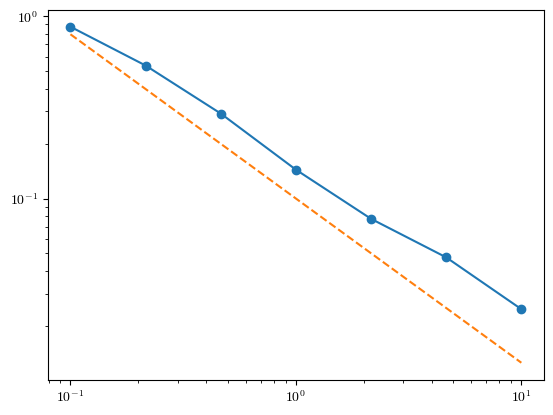

In [888]:
num, dum, zl = integrate_zph(zl)
step2 = num/dum
print(step2)
plt.loglog(r_p, step2, marker='o')
plt.plot(r_p, 0.1*grad, ls='dashed')
#plt.yticks([0.001, 0.01, 0.1, 1.0],['0.001', '0.01', '0.1', '1.0'],fontsize=14)

In [889]:
import multiprocessing as mp

# parallelised integration routine
iterables = list(range(len(z_l)))

# allocate array to store [B(rp) - 1] for each zl
num_igl_zph = np.zeros([len(z_l), len(r_p)])
denom_igl_zph = np.zeros([len(z_l), len(r_p)])
# parallelise previous 2 integrals to save run time
with mp.Pool(sp.poolsize) as p:
    # output values and process ID (imap should ensure correct order)
    num_igl_zph, denom_igl_zph, order = zip(*p.map(integrate_zph, iterables))

# run quick test to ensure order of outputs was preserved
check_order = list(order)
if check_order == iterables:
    print('Order preserved for zl indices %d-%d'%(iterables[0],iterables[-1]))
else:
    print('Order scrambled, data corrupted, exiting...')
    exit()

Order preserved for zl indices 0-299


In [890]:
# All [B(rp) - 1]_zl have been collected into a [len(z_l) x len(r_p)] array 
# dndz_l is already NORMALISED
num_igd_zl = dndz_l[:,None] * num_igl_zph 
denom_igd_zl = dndz_l[:,None] * denom_igl_zph

# compute final integral, which represents B - 1
# z_l values are axis 0
num_igl_zl = scipy.integrate.simps(num_igd_zl, z_l, axis=0)
denom_igl_zl = scipy.integrate.simps(denom_igd_zl, z_l, axis=0)

# combine to find unbinned boost values
B_unbin = num_igl_zl / denom_igl_zl
print(np.mean(np.gradient(B_unbin))/np.mean(B_unbin))

-0.5331069314941471


In [891]:
print(B_unbin)

[0.71632055 0.43146754 0.21976505 0.10202204 0.06075043 0.03904943
 0.0204746 ]


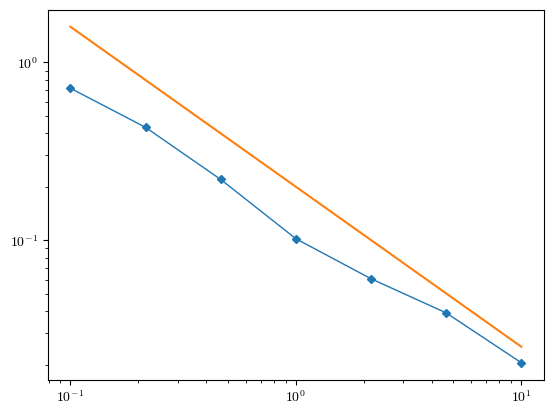

In [897]:
plt.plot(r_p, B_unbin, lw=1, marker='D', markersize=4.)
grad = r_p**(-0.9)
plt.plot(r_p, 0.2*grad)
plt.xscale('log')
plt.yscale('log')
#plt.yticks([0.001, 0.01, 0.1],['0.001', '0.01', '0.1'],fontsize=14)

In [893]:
# All [B(rp) - 1]_zl have been collected into a [len(z_l) x len(r_p)] array 
# dndz_l is already NORMALISED
cutnum_igd_zl = num_igl_zph[60:120] * dndz_l[60:120,None]
cutdenom_igd_zl = denom_igl_zph[60:120] * dndz_l[60:120,None]

# compute final integral, which represents B - 1
# z_l values are axis 0
cutnum_igl_zl = scipy.integrate.simps(cutnum_igd_zl, z_l[60:120], axis=0)
cutdenom_igl_zl = scipy.integrate.simps(cutdenom_igd_zl, z_l[60:120], axis=0)

# combine to find unbinned boost values
B_cut = cutnum_igl_zl / cutdenom_igl_zl

In [894]:
# All [B(rp) - 1]_zl have been collected into a [len(z_l) x len(r_p)] array 
# dndz_l is already NORMALISED
cutnum_igd_zl = num_igl_zph[180:240] * dndz_l[180:240,None]
cutdenom_igd_zl = denom_igl_zph[180:240] * dndz_l[180:240,None]

# compute final integral, which represents B - 1
# z_l values are axis 0
cutnum_igl_zl = scipy.integrate.simps(cutnum_igd_zl, z_l[180:240], axis=0)
cutdenom_igl_zl = scipy.integrate.simps(cutdenom_igd_zl, z_l[180:240], axis=0)

# combine to find unbinned boost values
B_cut_highZ = cutnum_igl_zl / cutdenom_igl_zl

In [899]:
print(B_cut)

[0.77451178 0.46590783 0.24013726 0.11183384 0.06426529 0.04100842
 0.02147717]


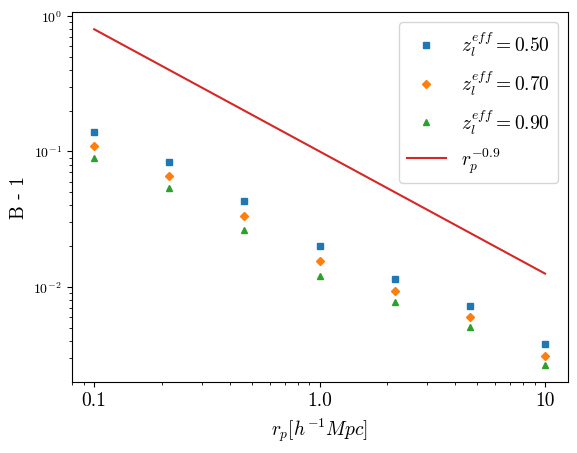

In [919]:
plt.plot(r_p, B_cut, lw=0, marker='s', markersize=4.)
plt.plot(r_p, B_unbin, lw=0, marker='D', markersize=4.)
plt.plot(r_p, B_cut_highZ, lw=0, marker='^', markersize=4.)
plt.plot(r_p, 0.1*grad)
# plt.plot(rp7, B_min1, lw=0, marker='^', markersize=3.)
plt.xscale('log')
plt.yscale('log')
#plt.ylim([0.001, 1])
#plt.yticks([0.001, 0.01, 0.1, 1.0],['0.001', '0.01', '0.1', '1.0'],fontsize=14)
plt.xticks([0.1, 1.0, 10.0], ['0.1','1.0','10'],fontsize=14)
plt.xlabel(r'$r_p [h^{-1} Mpc]$', fontsize=14)
plt.ylabel('B - 1', fontsize=14)
plt.legend([r'$z_l^{eff} = 0.50$',r'$z_l^{eff} = 0.70$', r'$z_l^{eff} = 0.90$',r'$r_p^{-0.9}$'],
          fontsize=14)
plt.savefig('boost_compare_B2012-like.png', bbox_inches='tight', dpi=300)

In [601]:
print(B_cut)

[1.82548833 1.31218874 0.70204737 0.20836474 0.04761898 0.02704723
 0.01423669]


In [90]:
np.average(z_l[180:240], weights=sp.zed.get_weights()*np.ones([len(z_l[180:240])]))

0.9006688963210698